In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

In [4]:
trainDir = r"/home/trojan/Desktop/dimentia/data_10slices/dataset with PGGAN/train"
input_shape = Input(shape=(256, 256, 3))
dropout_rate = 0.2
batch_size = 4

In [5]:
def lr_schedule(epoch):
    lr = 1e-4 #1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 80:
        lr *= 1e-3
    elif epoch > 40: # 120
        lr *= 1e-2
    elif epoch > 20: #80
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [6]:
train_datagen = ImageDataGenerator(rescale=1. / 255, validation_split=0.2)
train_generator = train_datagen.flow_from_directory(trainDir, target_size=(256, 256), batch_size=batch_size, 
                                                    class_mode='categorical', color_mode='rgb',
                                                   subset='training')

validation_generator = train_datagen.flow_from_directory(trainDir, target_size=(256, 256), batch_size=batch_size,
                                                     class_mode='categorical', color_mode='rgb',
                                                        subset='validation')

STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size

Found 15743 images belonging to 2 classes.
Found 3934 images belonging to 2 classes.


In [7]:
DenseNet121_1 = tf.keras.applications.DenseNet121(include_top=False, weights=None, input_shape = (256, 256, 3))
DenseNet121_1._name = 'DenseNet121_1'

DenseNet121_2 = tf.keras.applications.DenseNet121(include_top=False, weights=None, input_shape = (128, 128, 3))
DenseNet121_2._name = 'DenseNet121_2'

DenseNet121_3 = tf.keras.applications.DenseNet121(include_top=False, weights=None, input_shape = (64, 64, 3))
DenseNet121_3._name = 'DenseNet121_3'

In [8]:
cnn_top = DenseNet121_1(input_shape)
cnn_top = GlobalAveragePooling2D()(cnn_top)
cnn_top = Flatten()(cnn_top)
cnn_top = Dense(256)(cnn_top)

resized_mid = tf.keras.layers.experimental.preprocessing.Resizing(128, 128, interpolation='bilinear')(input_shape)
cnn_mid = DenseNet121_2(resized_mid)
cnn_mid = GlobalAveragePooling2D()(cnn_mid)
cnn_mid = Flatten()(cnn_mid)
cnn_mid = Dense(256)(cnn_mid)

resized_bot = tf.keras.layers.experimental.preprocessing.Resizing(64, 64, interpolation='bilinear')(input_shape)
cnn_bot = DenseNet121_3(resized_bot)
cnn_bot = GlobalAveragePooling2D()(cnn_bot)
cnn_bot = Flatten()(cnn_bot)
cnn_bot = Dense(256)(cnn_bot)

In [9]:
merged_model = concatenate([cnn_top, cnn_mid, cnn_bot])

final_model = Dropout(dropout_rate)(merged_model)
final_model = Dense(128)(merged_model)
final_model = Dropout(dropout_rate)(final_model)
final_model = Dense(2)(final_model)
final_model = Activation('softmax')(final_model)

final_model = Model(input_shape, final_model)

In [10]:
final_model.compile(optimizer=tf.keras.optimizers.Adam(lr=lr_schedule(0)),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

final_model.summary()

Learning rate:  0.0001
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
resizing (Resizing)             (None, 128, 128, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
resizing_1 (Resizing)           (None, 64, 64, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
DenseNet121_1 (Functional)      (None, 8, 8, 1024)   7037504     input_2[0][0]                    
________________________________________________________________

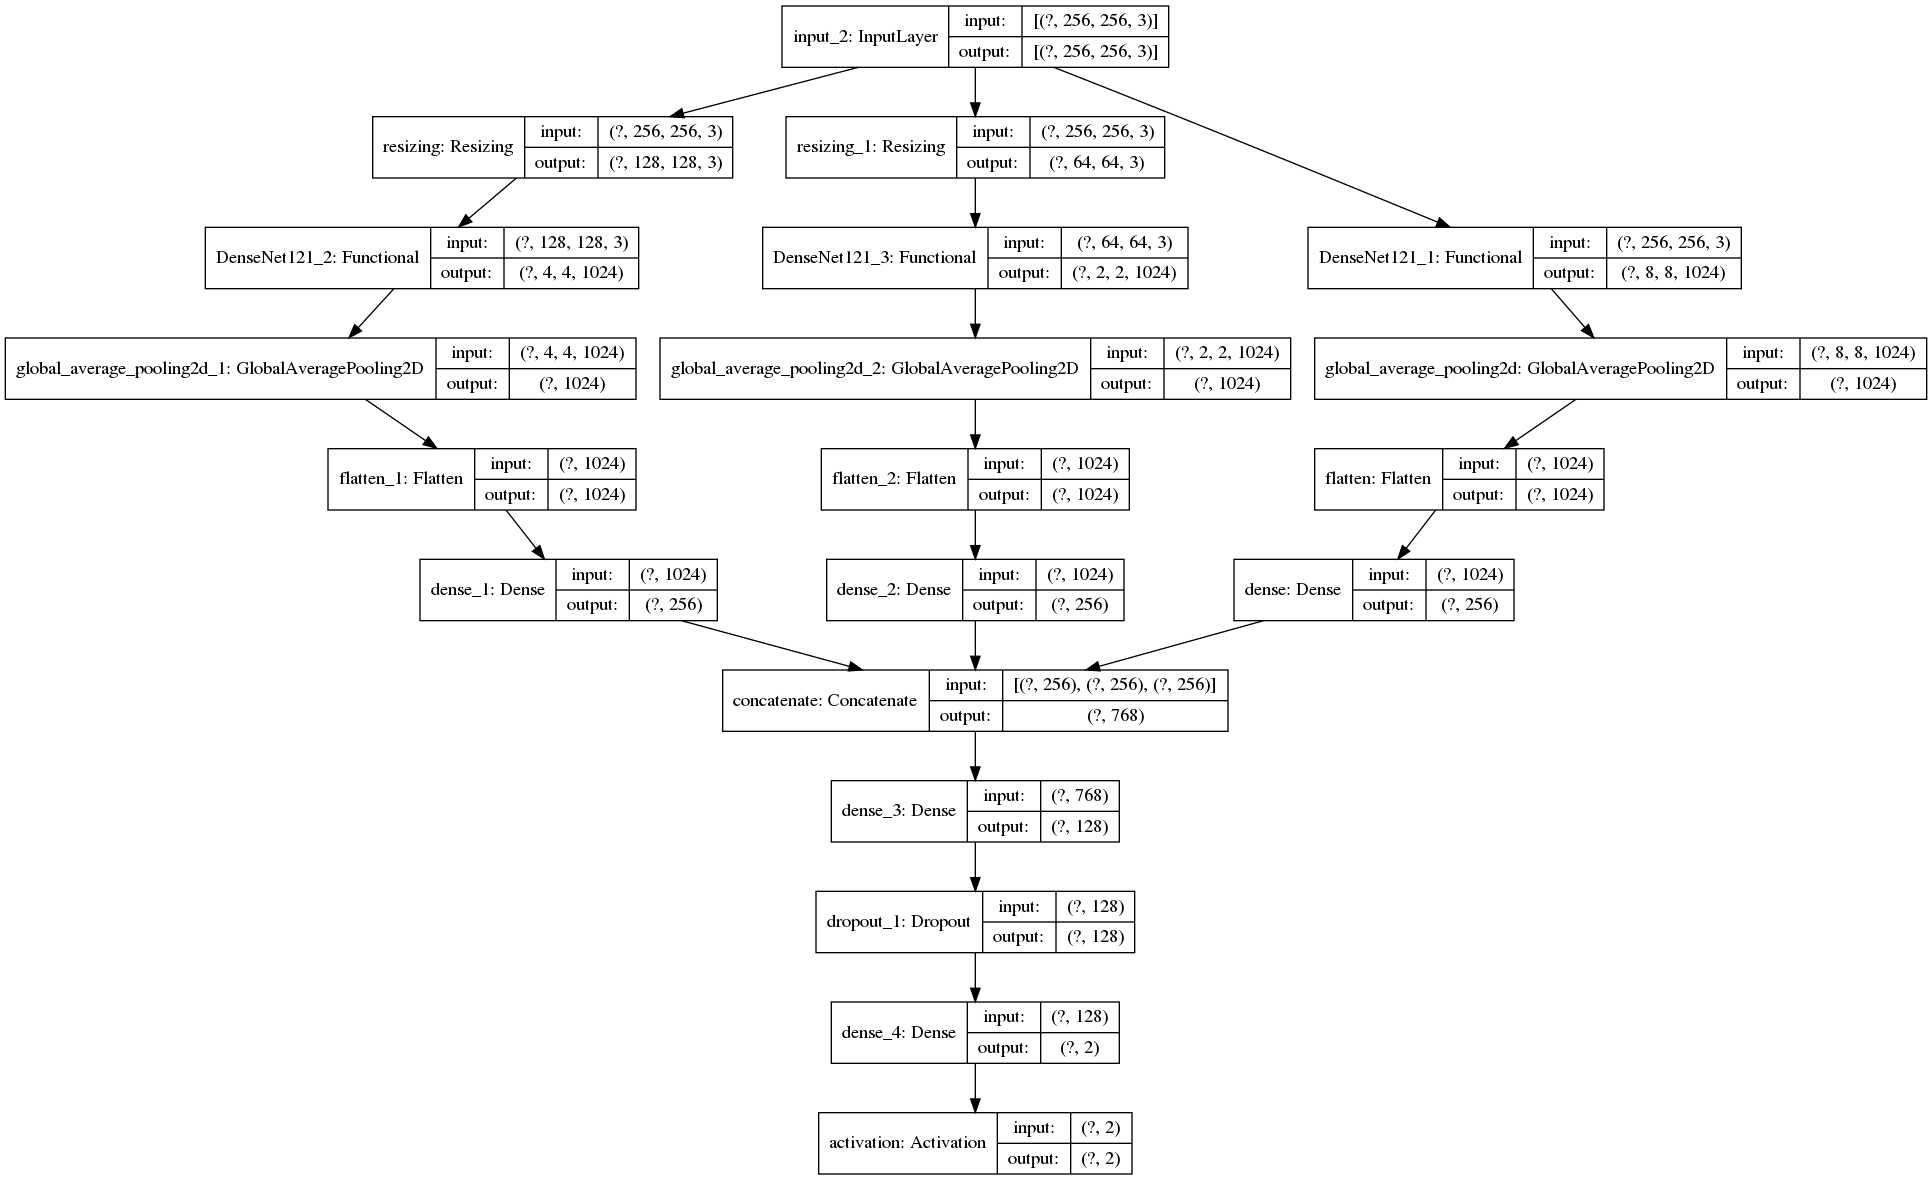

In [11]:
tf.keras.utils.plot_model(final_model, to_file='my_model.png', show_shapes=True)

In [15]:
checkpoint = ModelCheckpoint('best_model_DenseNet.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True, save_weights_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

In [16]:
#final_train_generator = zip(train_generator, train_generator, train_generator)
#final_test_generator  = zip(test_generator, test_generator, test_generator)
final_model.fit_generator(train_generator, steps_per_epoch=STEP_SIZE_TRAIN, epochs=50,
                          validation_data=validation_generator, verbose=1, workers=1, 
                          validation_steps=STEP_SIZE_VALID, callbacks=checkpoint)

Epoch 1/50
3935/3935 [==============================] - ETA: 0s - loss: 0.4614 - accuracy: 0.7925
Epoch 00001: val_accuracy improved from -inf to 0.74898, saving model to best_model_DenseNet.h5
3935/3935 [==============================] - 482s 122ms/step - loss: 0.4614 - accuracy: 0.7925 - val_loss: 0.5093 - val_accuracy: 0.7490
Epoch 2/50
  75/3935 [..............................] - ETA: 7:24 - loss: 0.3514 - accuracy: 0.8333

KeyboardInterrupt: 

In [22]:
final_model.load_weights('best_model_DenseNet.h5')

In [23]:
score = final_model.evaluate_generator(generator=validation_generator, verbose=1,
steps=STEP_SIZE_VALID)

print("Loss: ", score[0], "Accuracy: ", score[1])

Instructions for updating:
Please use Model.evaluate, which supports generators.
759/983 [======================>.......] - ETA: 7s - loss: 0.4903 - accuracy: 0.7543

KeyboardInterrupt: 